# Plot qPCR to analyze export using stable genomically integrated transgenes

# Introduction

## Imports

In [1]:
import sys
import os
import time

import numpy as np
import scipy
import pandas as pd

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns

## Set output parameters

In [2]:
# Set pandas display options
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

# Set plot display options
FONTSIZE = 8  # universal fontsize
params = {
    'font.size': FONTSIZE,
    'axes.titlesize': FONTSIZE,
    'axes.labelsize': FONTSIZE,
    'legend.fontsize': FONTSIZE,
    'xtick.labelsize': FONTSIZE,
    'ytick.labelsize': FONTSIZE,
    'font.family': "Helvetica",
    'mathtext.fontset': 'custom',
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'figure.dpi': 300
   }
mpl.rcParams.update(params)
sns.set_style("ticks", {'axes.grid' : False})

# Set plot output options
output_dir = "outs/qPCR_stable_cell_line"
output_suffix = ""
output_formats = [".png", ".pdf"]

mpl.rc('savefig', dpi=300)

# Define convenience function for saving figures

savefig = True
savefig_args = {"dpi": 300, "bbox_inches": "tight", "pad_inches": 0.1}

def save_figure(fig, name, output_dir=output_dir, output_suffix=output_suffix, output_formats=output_formats, savefig_args=savefig_args):
    if savefig:
        for output_format in output_formats:
            fig.savefig(output_dir + "/" + name + output_suffix + output_format, **savefig_args)
    return None

In [3]:
# Report plot parameters
sns.plotting_context()

{'font.size': 8.0,
 'axes.labelsize': 8.0,
 'axes.titlesize': 8.0,
 'xtick.labelsize': 8.0,
 'ytick.labelsize': 8.0,
 'legend.fontsize': 8.0,
 'legend.title_fontsize': None,
 'axes.linewidth': 0.8,
 'grid.linewidth': 0.8,
 'lines.linewidth': 1.5,
 'lines.markersize': 6.0,
 'patch.linewidth': 1.0,
 'xtick.major.width': 0.8,
 'ytick.major.width': 0.8,
 'xtick.minor.width': 0.6,
 'ytick.minor.width': 0.6,
 'xtick.major.size': 3.5,
 'ytick.major.size': 3.5,
 'xtick.minor.size': 2.0,
 'ytick.minor.size': 2.0}

# Load data

## Load qPCR data

In [4]:
infile = "../preprocessed_data/qPCR_data/qPCR_stable_cell_line.csv"

cq_raw = pd.read_csv(infile, header=0)

columns_to_drop = ["Unnamed: 0", "Well Note", "Set Point"]
cq_raw.drop(columns_to_drop, axis=1, inplace=True)

cq_raw = cq_raw.set_index("Sample")

print(cq_raw.shape)
cq_raw.head()

(9, 12)


,Well,Fluor,Target,Content,Biological Set Name,Cq,Cq Mean,Cq Std. Dev,Starting Quantity (SQ),Log Starting Quantity,SQ Mean,SQ Std. Dev
Sample,,,,,,,,,,,,
96-7,A07,SYBR,mCherry,Unkn-07,NaN,30.328827,30.166750,0.189795,148.639053,2.172133,166.236455,21.157494
96-10,A10,SYBR,mCherry,Unkn-10,NaN,35.873826,35.830884,0.556779,3.871437,0.587872,4.164997,1.530487
96-11,A11,SYBR,mCherry,Unkn-11,NaN,36.911466,36.523586,0.339203,1.956177,0.291408,2.565245,0.534915
96-7,B07,SYBR,mCherry,Unkn-07,NaN,30.213463,30.166750,0.189795,160.359048,2.205093,166.236455,21.157494
96-10,B10,SYBR,mCherry,Unkn-10,NaN,36.364948,35.830884,0.556779,2.802553,0.447554,4.164997,1.530487


# Preprocess data

## Calculate total starting molecules

In [5]:
# Calculate normalization for input volume
DILUTION_FACTORS = (400/140) * (42/20) * (61/10) * (20/1)

In [6]:
# Back-calculate input RNA molecules, given <100% efficiency of extraction, DNase, RT, as measured based on RNA standard

PROTOCOL_EFFICIENCY = 0.005957820738  # Efficiency of extraction, DNase, RT

In [7]:
# Calculate total RNA molecules in supernatant
cq_raw["RNA molecules"] = cq_raw["Starting Quantity (SQ)"] * DILUTION_FACTORS * (1/PROTOCOL_EFFICIENCY)
cq_raw["RNA molecules Mean"] = cq_raw["SQ Mean"] * DILUTION_FACTORS * (1/PROTOCOL_EFFICIENCY)
cq_raw["RNA molecules STD"] = cq_raw["SQ Std. Dev"] * DILUTION_FACTORS * (1/PROTOCOL_EFFICIENCY)

## Summarize replicates

In [8]:
groups = cq_raw.groupby(["Sample"])  # group samples by origin

summary = pd.DataFrame()

summary["mean SQ"] = groups["Starting Quantity (SQ)"].mean()  # Calculate mean over replicates
summary["std SQ"] = groups["Starting Quantity (SQ)"].std()  # Calculate mean over replicates

summary["RNA molecules"] = groups["RNA molecules"].mean()
summary["RNA molecules STD"] = groups["RNA molecules STD"].mean()

summary

,mean SQ,std SQ,RNA molecules,RNA molecules STD
Sample,,,,
96-10,4.164997,1.530487,5.117270e+05,1.880413e+05
96-11,2.565245,0.534915,3.151756e+05,6.572161e+04
96-7,166.236455,21.157494,2.042443e+07,2.599488e+06


## Censor by lower limit of quantification

In [9]:
# Lower limit of quantification is set based on maximum signal from negative control (HEK293T) wells.

LOD = cq_raw.loc["96-11", "RNA molecules"].max()

print("Lower limit of quantification:", LOD)

Lower limit of quantification: 363519.53231284645


In [10]:
# Substitute LOD for values below LOD

cq_raw["RNA molecules censored"] = cq_raw["RNA molecules"]
cq_raw.loc[cq_raw["RNA molecules"] < LOD, "RNA molecules censored"] = LOD

summary["RNA molecules censored"] = summary["RNA molecules"]
summary.loc[summary["RNA molecules"] < LOD, "RNA molecules censored"] = LOD

# Visualize RNA export via stable genomic integration of exporter

In [11]:
# Choose samples
index_ordered = ["96-7", "96-10"]

In [12]:
# Get data of summary across replicates of selected wells
summary_subset = summary.loc[index_ordered]

# Set label
# summary_subset["label"] = [column_to_label[col] for col in columns_ordered]

print(summary_subset.shape)
summary_subset

(2, 5)


,mean SQ,std SQ,RNA molecules,RNA molecules STD,RNA molecules censored
Sample,,,,,
96-7,166.236455,21.157494,2.042443e+07,2.599488e+06,2.042443e+07
96-10,4.164997,1.530487,5.117270e+05,1.880413e+05,5.117270e+05


In [13]:
# Get data of replicates of selected wells
selector = cq_raw.index.isin(index_ordered)
data = cq_raw.loc[selector]

data = data.reset_index()

print(data.shape)
data.head()

(6, 17)


,Sample,Well,Fluor,Target,Content,Biological Set Name,Cq,Cq Mean,Cq Std. Dev,Starting Quantity (SQ),Log Starting Quantity,SQ Mean,SQ Std. Dev,RNA molecules,RNA molecules Mean,RNA molecules STD,RNA molecules censored
0,96-7,A07,SYBR,mCherry,Unkn-07,NaN,30.328827,30.166750,0.189795,148.639053,2.172133,166.236455,21.157494,1.826235e+07,2.042443e+07,2.599488e+06,1.826235e+07
1,96-10,A10,SYBR,mCherry,Unkn-10,NaN,35.873826,35.830884,0.556779,3.871437,0.587872,4.164997,1.530487,4.756591e+05,5.117270e+05,1.880413e+05,4.756591e+05
2,96-7,B07,SYBR,mCherry,Unkn-07,NaN,30.213463,30.166750,0.189795,160.359048,2.205093,166.236455,21.157494,1.970231e+07,2.042443e+07,2.599488e+06,1.970231e+07
3,96-10,B10,SYBR,mCherry,Unkn-10,NaN,36.364948,35.830884,0.556779,2.802553,0.447554,4.164997,1.530487,3.443320e+05,5.117270e+05,1.880413e+05,3.635195e+05
4,96-7,C07,SYBR,mCherry,Unkn-07,NaN,29.957960,30.166750,0.189795,189.711264,2.278093,166.236455,21.157494,2.330863e+07,2.042443e+07,2.599488e+06,2.330863e+07


findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


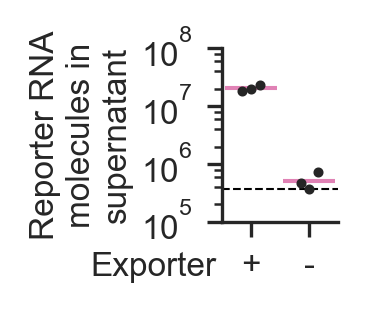

In [14]:
# Make simple swarm plot with smaller height

field = "RNA molecules censored"

fig, ax = plt.subplots(1, 1, figsize=(0.5, 0.75))

# Set axis scaling - must be done first so swarm plot dots do not overlap
ax.set_yscale("log")
ax.set_ylim(1e5, 1e8)

# Plot summary

y = summary_subset[field]
x = np.arange(len(y))

sns.scatterplot(ax=ax, x=x, y=y, marker="_", s=150, color="#e082b5")

# Plot individual points as swarm (sort columns appropriately)

sample_to_rank = dict(zip(index_ordered, range(len(index_ordered))))
data["rank"] = [sample_to_rank[s] for s in data["Sample"]]
data = data.sort_values(by="rank")

y_swarm = data[field]
x_swarm = np.array([x[rank] for rank in data["rank"]])

x_offset = np.array([-0.15, 0, 0.15])  # jitter offsets to avoid operlaps
x_swarm_offset = x_swarm + np.tile(x_offset, int(len(x_swarm)/len(x_offset)))

ax.scatter(x_swarm_offset, y_swarm, color="#252525", s=2, zorder=10)

ax.set_xlim(min(x)-0.5, max(x)+0.5)

ax.set_ylabel("Reporter RNA\nmolecules in\nsupernatant", labelpad=2)

locmaj = mpl.ticker.LogLocator(base=10,numticks=12) 
ax.yaxis.set_major_locator(locmaj)

locmin = mpl.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=12)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())

# ax.set_yticks([1, 10, 100, 1000])
# ax.set_yticklabels([1, 10, r"$10^2$", r"$10^3$"])

ax.set_xticks([0, 1])
xticklabels = ["+", "-"]
ax.set_xticklabels(xticklabels)

ax.text(-0.6, 3e4, "Exporter", ha="right", va="top", size=FONTSIZE)

ax.set_xlabel("")

LOD = cq_raw.loc["96-11", "RNA molecules censored"].max()
ax.axhline(LOD, ls="--", color="k", lw=0.5, zorder=-1)

sns.despine()

save_figure(fig, "export_from_stable_HEK293")

In [15]:
# Report enrichment
print("Fold enrichment:", summary.loc["96-7", "RNA molecules censored"] / summary.loc["96-10", "RNA molecules censored"])

Fold enrichment: 39.912744454393895
